In [1]:
import torch
import torchvision

In [2]:
!mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True,download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False,download=True,transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=64, shuffle=True)

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 30, kernel_size=7)
        self.drop_1 = nn.Dropout2d()
        self.conv2 = nn.Conv2d(30, 40, kernel_size=5)
        self.drop_2 = nn.Dropout2d()
        self.conv3 = nn.Conv2d(40, 60, kernel_size=3)
        self.drop_3 = nn.Dropout2d()
        self.fc1 = nn.Linear(15360, 5000)
        self.fc2 = nn.Linear(5000, 500)
        self.fc3 = nn.Linear(500, 50)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.drop_1(self.conv1(x)))
        x = F.relu(self.drop_2(self.conv2(x)))
        x = F.relu(self.drop_3(self.conv3(x)))
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.5)

In [7]:
from torchviz import make_dot

In [8]:
data , label = next(iter(train_loader))
y = model(data)
make_dot(y, params=dict(model.named_parameters())).render("comp_graph", format="png")

'comp_graph.png'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_losses = []
test_loss =0
train_losses = []
test_counter = []
accuracy = []
count = 0
model.cuda()
for epoch in range(1, 5):
    for data, target in iter(train_loader):
        model.train()
        optimizer.zero_grad()
        output = model(data.to(device))
        loss = F.cross_entropy(output, target.to( device))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        count += 1
        model.eval()
        with torch.no_grad():
            data , target = next(iter(test_loader))
            output = model(data.to( device))
            test_loss = F.cross_entropy(output, target.to( device)).item()
            test_losses.append(test_loss)
            test_counter.append(count)
            accuracy.append((sum(torch.argmax(output, dim = 1) == target.to( device))/64).item())


In [10]:
import matplotlib.pyplot as plt

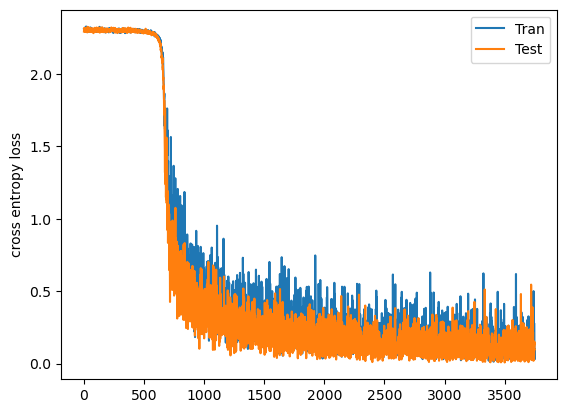

In [11]:
fig = plt.figure()
plt.ylabel('cross entropy loss')
plt.plot(train_losses,label= "Tran")
plt.plot(test_losses, label= "Test")
plt.legend()
plt.savefig('train.png')